In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [23]:
data=pd.read_csv('/kaggle/input/weather-data/weather_data.csv')

In [22]:
data.head()

,date,avg_temperature,humidity,avg_wind_speed,rain_or_not,cloud_cover,pressure
0,2023-01-01,23.745401,46.140905,7.845981,Rain,20.851051,992.965681
1,2023-01-02,30.030503,59.876587,5.382457,Rain,93.059521,1037.273025
2,2023-01-03,28.365224,51.464618,13.158008,Rain,11.636640,1034.193357
3,2023-01-04,27.550929,53.103799,5.886677,Rain,81.744971,968.610142
4,2023-01-05,23.639303,57.826186,12.248992,Rain,38.062329,1030.264331


In [24]:
data.duplicated().sum()

0

In [25]:
data.isnull().sum()

date                0
avg_temperature    15
humidity           15
avg_wind_speed     15
rain_or_not         0
cloud_cover        15
pressure            0
dtype: int64

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             311 non-null    object 
 1   avg_temperature  296 non-null    float64
 2   humidity         296 non-null    float64
 3   avg_wind_speed   296 non-null    float64
 4   rain_or_not      311 non-null    object 
 5   cloud_cover      296 non-null    float64
 6   pressure         311 non-null    float64
dtypes: float64(5), object(2)
memory usage: 17.1+ KB


# Handling Missing Values

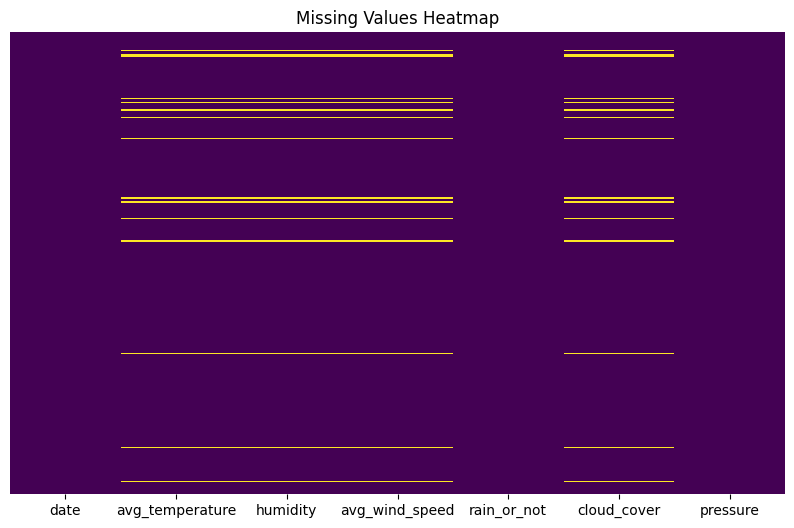

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize missing values using a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values Heatmap')
plt.show()

In [28]:
# Median imputation for numerical columns
numerical_columns = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']
for col in numerical_columns:
    data[col].fillna(data[col].median(), inplace=True)

# Verify missing values are handled
print("\nMissing values after imputation:")
print(data.isnull().sum())



Missing values after imputation:
date               0
avg_temperature    0
humidity           0
avg_wind_speed     0
rain_or_not        0
cloud_cover        0
pressure           0
dtype: int64


<ipython-input-28-f621dc7cf035>:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data[col].fillna(data[col].median(), inplace=True)


# Feature Engineering

In [29]:
# Convert 'date' column to datetime format
data['date'] = pd.to_datetime(data['date'])

# Add 'season' feature
data['season'] = (data['date'].dt.month % 12) // 3 + 1

# Add 'weekday' feature (0=Monday, 6=Sunday)
data['weekday'] = data['date'].dt.weekday


# Extract year, month, and day

data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day

# Drop the original 'date' column (optional)
data.drop('date', axis=1, inplace=True)

# Display the updated DataFrame
print("\nUpdated DataFrame:")
print(data.head())


Updated DataFrame:
   avg_temperature   humidity  avg_wind_speed rain_or_not  cloud_cover  \
0        23.745401  46.140905        7.845981        Rain    20.851051   
1        30.030503  59.876587        5.382457        Rain    93.059521   
2        28.365224  51.464618       13.158008        Rain    11.636640   
3        27.550929  53.103799        5.886677        Rain    81.744971   
4        23.639303  57.826186       12.248992        Rain    38.062329   

      pressure  season  weekday  month  day  
0   992.965681       1        6      1    1  
1  1037.273025       1        0      1    2  
2  1034.193357       1        1      1    3  
3   968.610142       1        2      1    4  
4  1030.264331       1        3      1    5  


In [30]:
data['rain_or_not'].value_counts()

rain_or_not
Rain       198
No Rain    113
Name: count, dtype: int64

In [31]:
# Map 'Rain' to 1 and 'No Rain' to 0
data['rain_or_not'] = data['rain_or_not'].map({'Rain': 1, 'No Rain': 0})

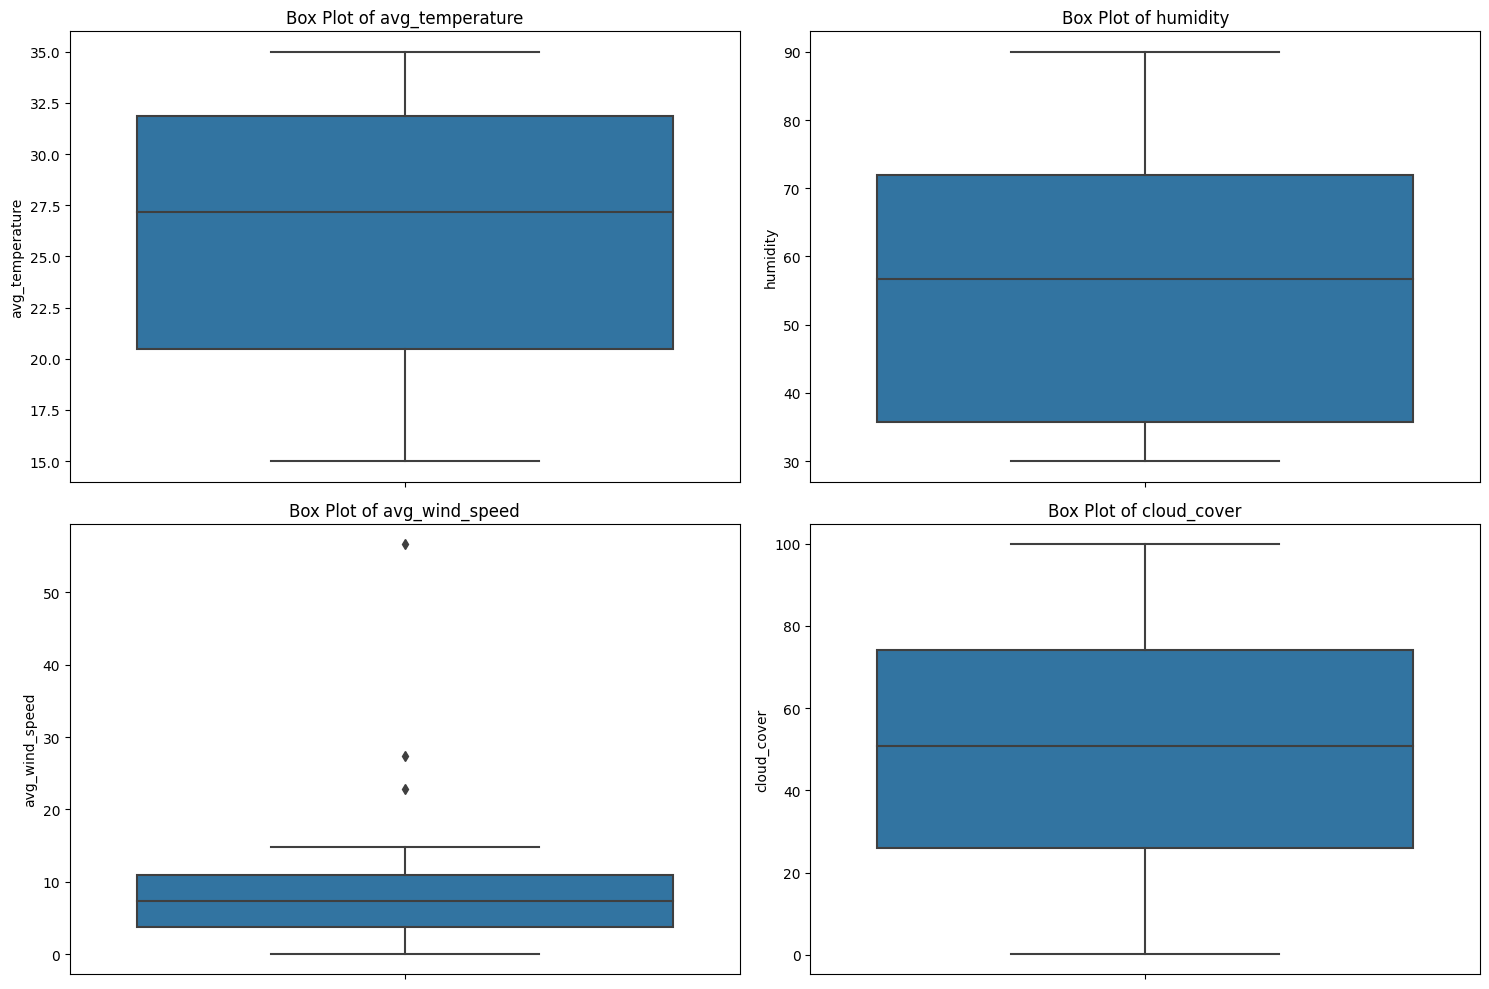

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# List of numerical columns to plot
numerical_columns = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']

# Create box plots
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(y=data[col])
    plt.title(f'Box Plot of {col}')
plt.tight_layout()
plt.show()

# Outlier Detection and Handling

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# List of numerical columns
numerical_columns = ['avg_temperature', 'humidity', 'avg_wind_speed', 'cloud_cover']

# Calculate IQR and identify outliers
for col in numerical_columns:
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f'IQR for {col}: {IQR:.2f}')
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    print(f'Outliers in {col}: {len(outliers)}')



IQR for avg_temperature: 11.37
Outliers in avg_temperature: 0
IQR for humidity: 36.29
Outliers in humidity: 0
IQR for avg_wind_speed: 7.19
Outliers in avg_wind_speed: 3
IQR for cloud_cover: 48.21
Outliers in cloud_cover: 0


Clipped avg_wind_speed:
count    311.000000
mean       7.410985
std        4.393116
min        0.069480
25%        3.711684
50%        7.326421
75%       10.897166
max       21.675390
Name: avg_wind_speed, dtype: float64


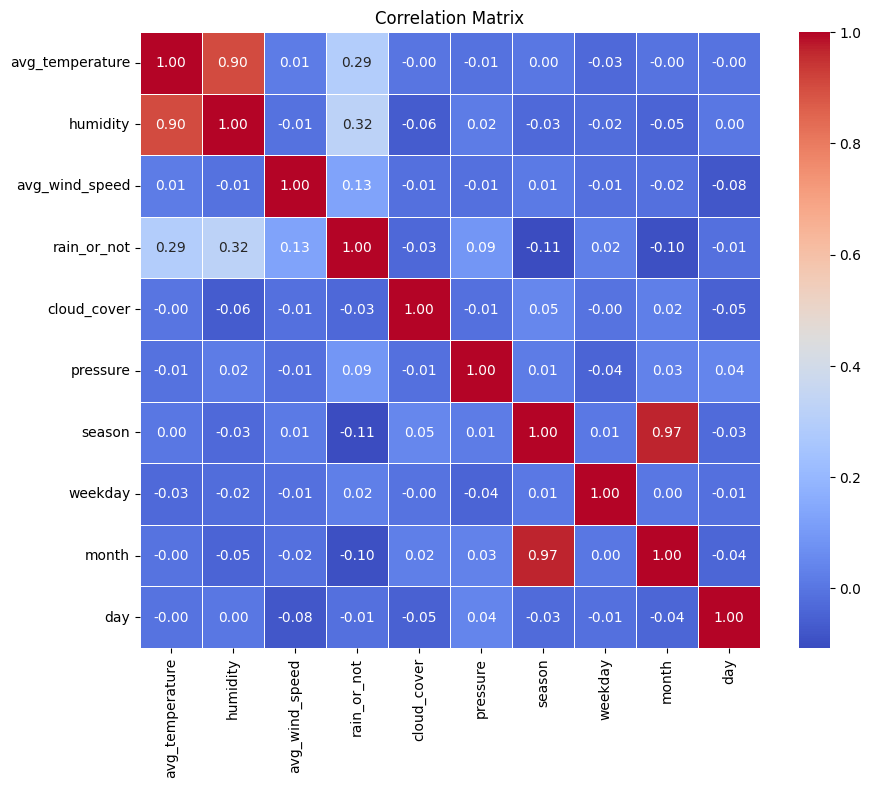

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Clip outliers in avg_wind_speed
Q1 = data['avg_wind_speed'].quantile(0.25)
Q3 = data['avg_wind_speed'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

data['avg_wind_speed'] = data['avg_wind_speed'].clip(lower=lower_bound, upper=upper_bound)

# Verify clipping
print("Clipped avg_wind_speed:")
print(data['avg_wind_speed'].describe())

# Calculate correlation matrix
corr_matrix = data.corr()

# Visualize correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

# EDA

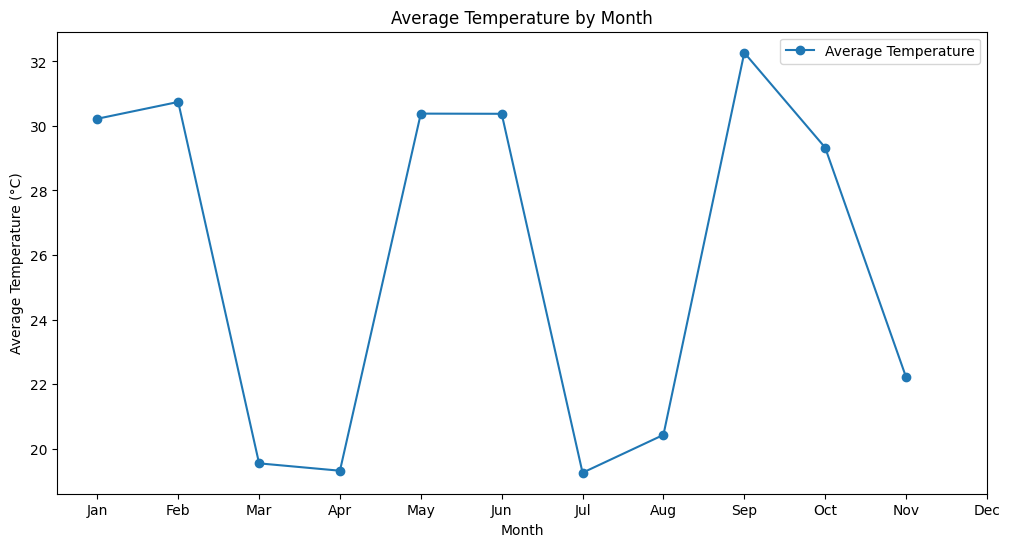

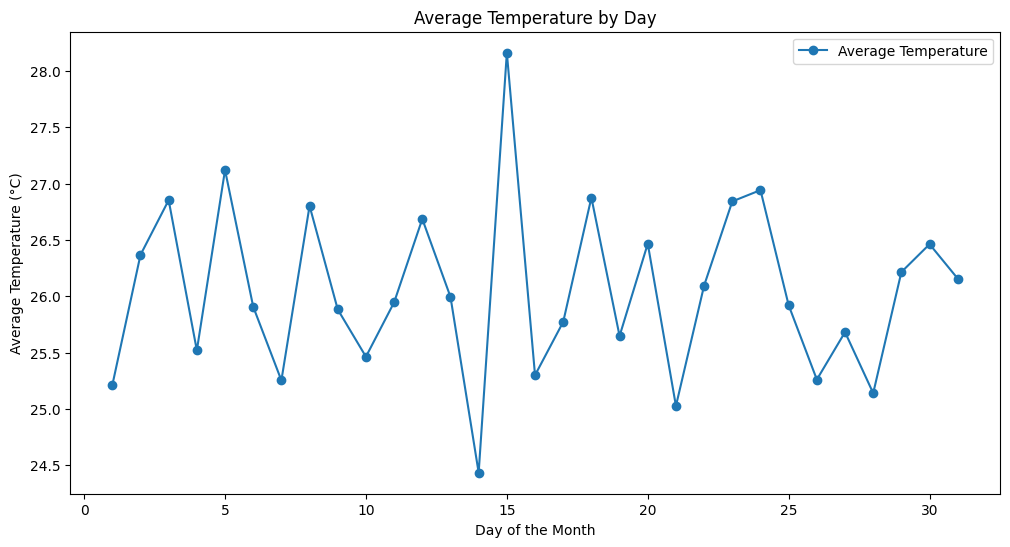

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


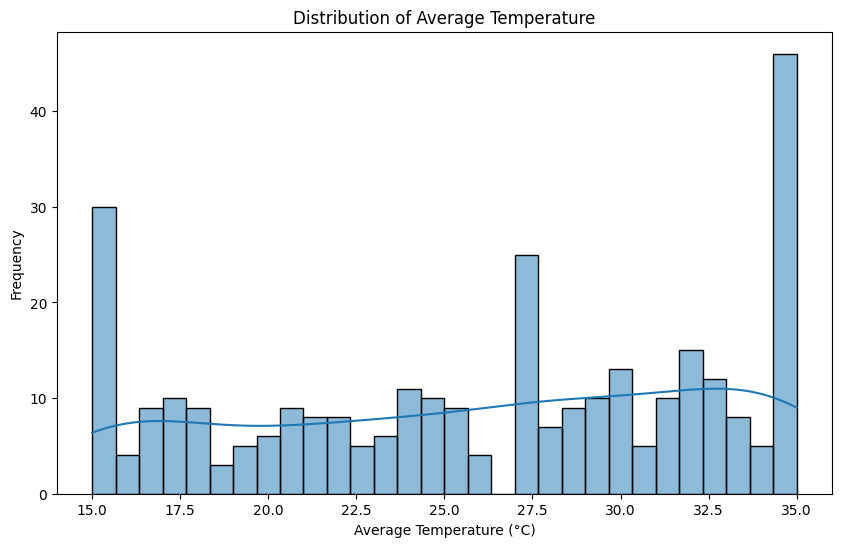

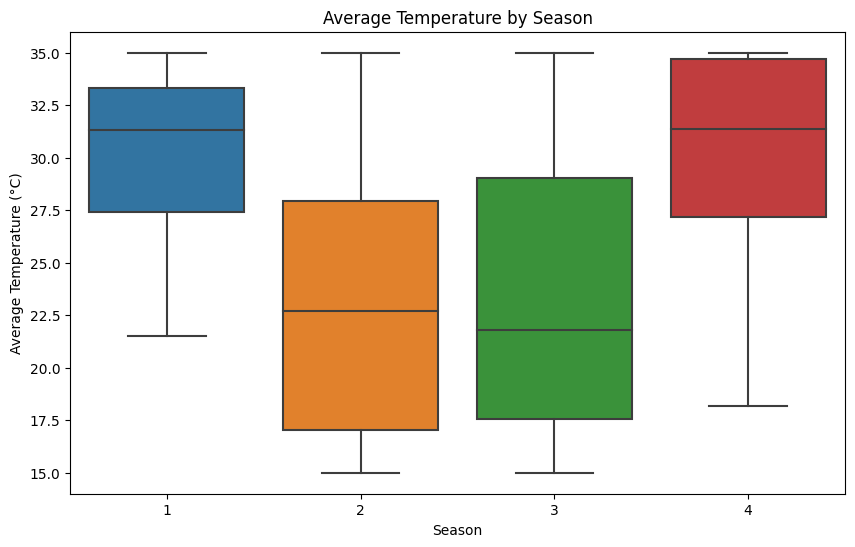

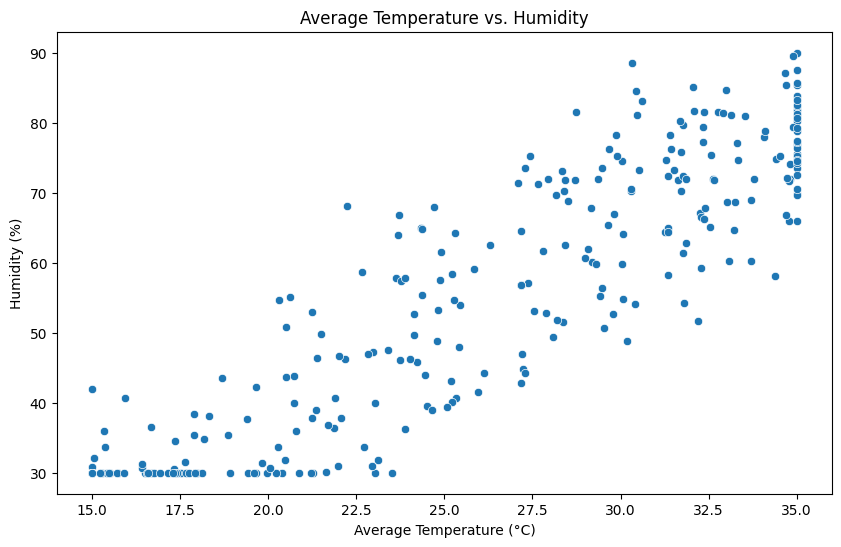

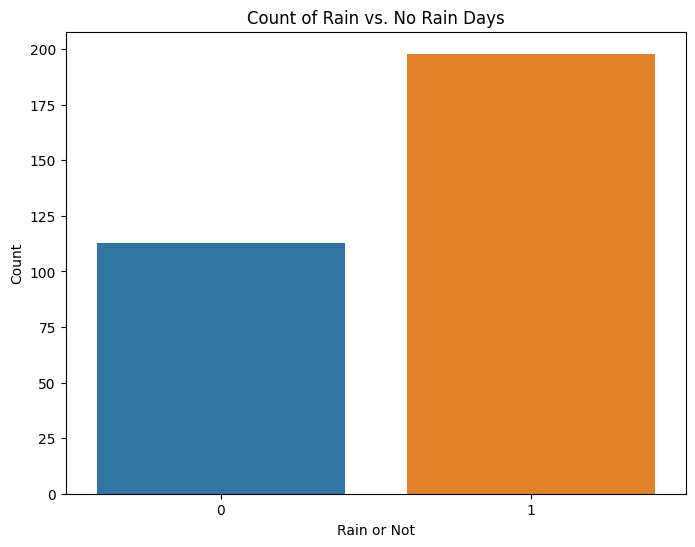

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib.pyplot as plt
import seaborn as sns


# Group by month and calculate mean temperature
monthly_avg_temp = data.groupby('month')['avg_temperature'].mean()

# Plot Average Temperature by Month
plt.figure(figsize=(12, 6))
plt.plot(monthly_avg_temp.index, monthly_avg_temp.values, label='Average Temperature', marker='o')
plt.title('Average Temperature by Month')
plt.xlabel('Month')
plt.ylabel('Average Temperature (°C)')
plt.xticks(range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend()
plt.show()

# Group by day and calculate mean temperature
daily_avg_temp = data.groupby('day')['avg_temperature'].mean()

# Plot Average Temperature by Day
plt.figure(figsize=(12, 6))
plt.plot(daily_avg_temp.index, daily_avg_temp.values, label='Average Temperature', marker='o')
plt.title('Average Temperature by Day')
plt.xlabel('Day of the Month')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.show()

# Histogram of Average Temperature
plt.figure(figsize=(10, 6))
sns.histplot(data['avg_temperature'], bins=30, kde=True)
plt.title('Distribution of Average Temperature')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

# Box Plot of Average Temperature by Season
plt.figure(figsize=(10, 6))
sns.boxplot(x='season', y='avg_temperature', data=data)
plt.title('Average Temperature by Season')
plt.xlabel('Season')
plt.ylabel('Average Temperature (°C)')
plt.show()

# Scatter Plot: Average Temperature vs. Humidity
plt.figure(figsize=(10, 6))
sns.scatterplot(x='avg_temperature', y='humidity', data=data)
plt.title('Average Temperature vs. Humidity')
plt.xlabel('Average Temperature (°C)')
plt.ylabel('Humidity (%)')
plt.show()



# Bar Plot of Rain vs. No Rain
plt.figure(figsize=(8, 6))
sns.countplot(x='rain_or_not', data=data)
plt.title('Count of Rain vs. No Rain Days')
plt.xlabel('Rain or Not')
plt.ylabel('Count')
plt.show()





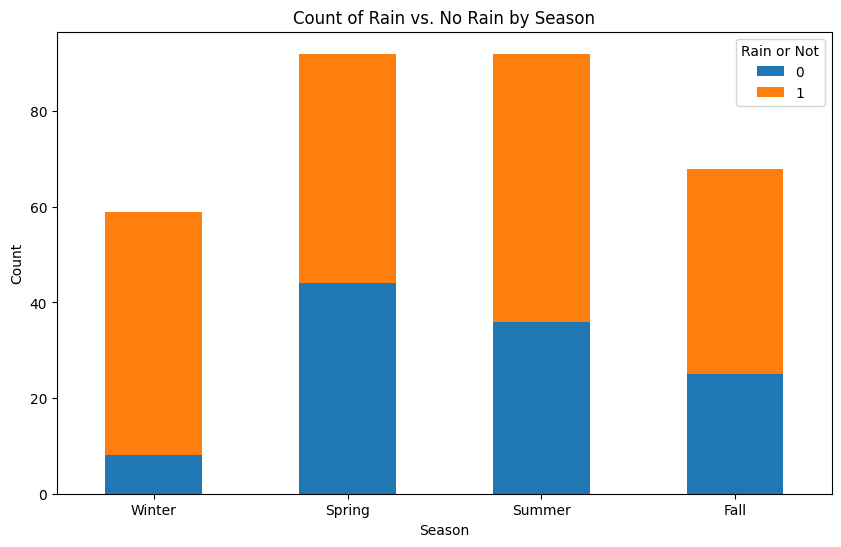

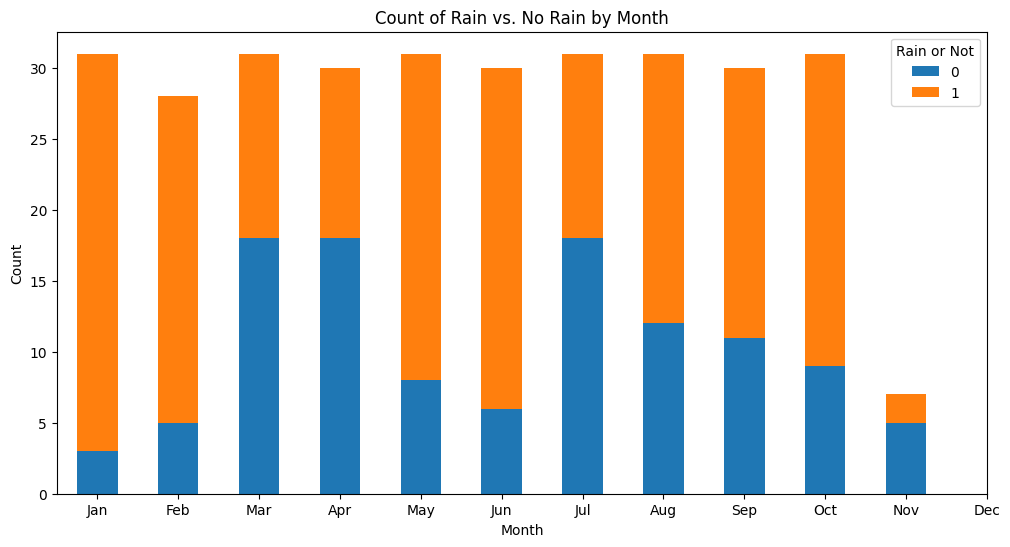

In [39]:
# Count of Rain/No Rain by Season
rain_by_season = data.groupby(['season', 'rain_or_not']).size().unstack()

# Plot the results
rain_by_season.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Count of Rain vs. No Rain by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Winter', 'Spring', 'Summer', 'Fall'], rotation=0)
plt.legend(title='Rain or Not')
plt.show()


# Count of Rain/No Rain by Month
rain_by_month = data.groupby(['month', 'rain_or_not']).size().unstack()

# Plot the results
rain_by_month.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Count of Rain vs. No Rain by Month')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=0)
plt.legend(title='Rain or Not')
plt.show()

There's a clear association between possibility of rain and month,season.

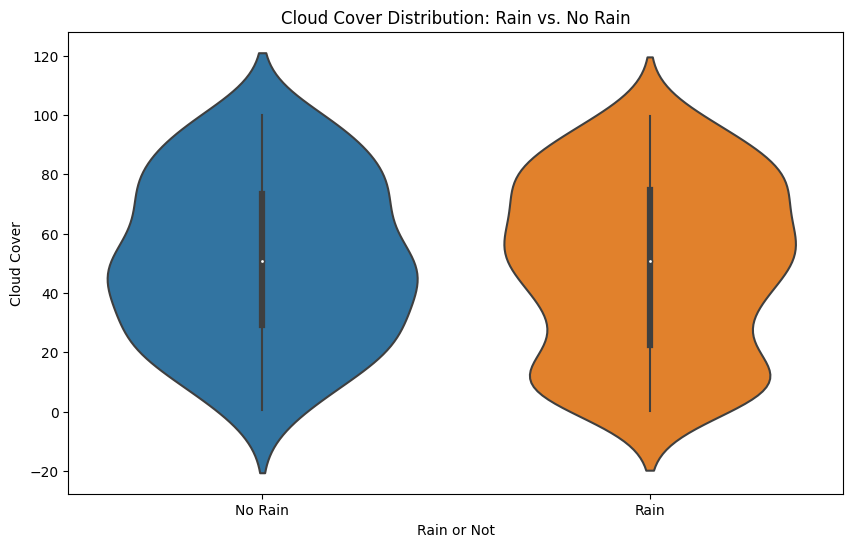

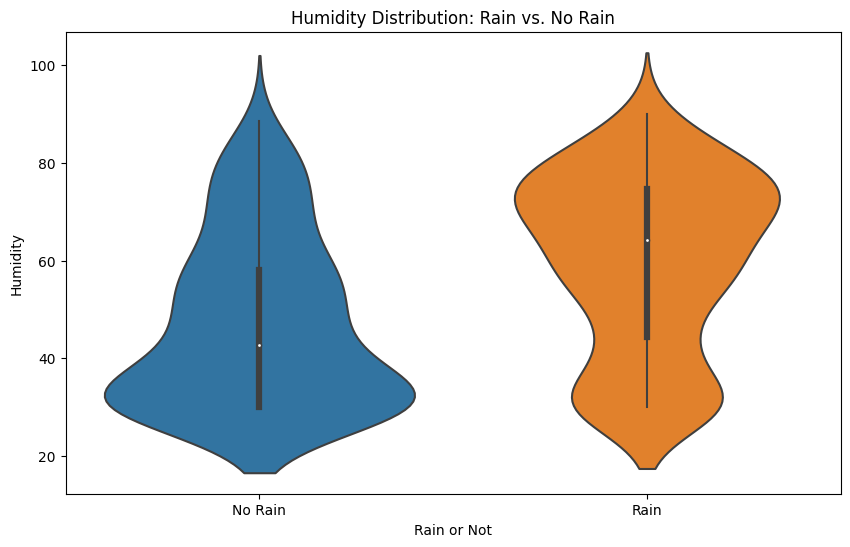

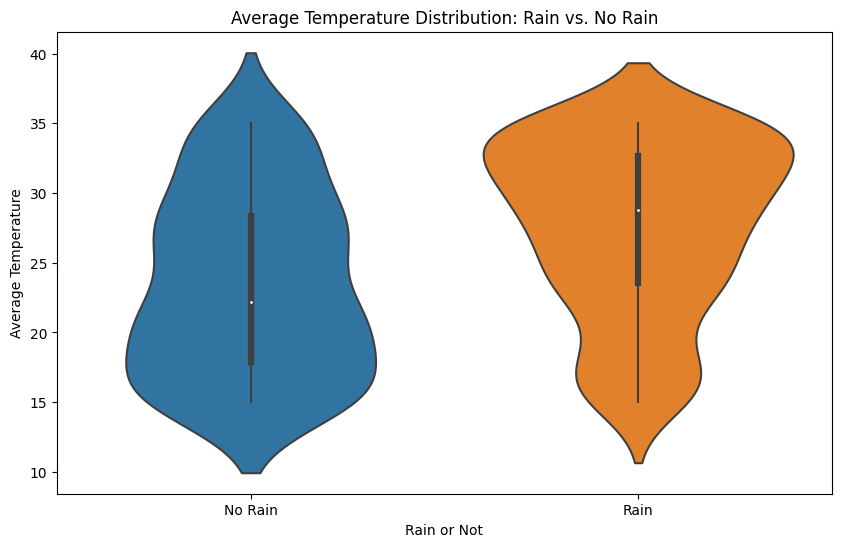

In [42]:
# Violin Plot: Cloud Cover vs. Rain/No Rain
plt.figure(figsize=(10, 6))
sns.violinplot(x='rain_or_not', y='cloud_cover', data=data)
plt.title('Cloud Cover Distribution: Rain vs. No Rain')
plt.xlabel('Rain or Not')
plt.ylabel('Cloud Cover')
plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])
plt.show()


plt.figure(figsize=(10, 6))
sns.violinplot(x='rain_or_not', y='humidity', data=data)
plt.title('Humidity Distribution: Rain vs. No Rain')
plt.xlabel('Rain or Not')
plt.ylabel('Humidity')
plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x='rain_or_not', y='avg_temperature', data=data)
plt.title('Average Temperature Distribution: Rain vs. No Rain')
plt.xlabel('Rain or Not')
plt.ylabel('Average Temperature')
plt.xticks(ticks=[0, 1], labels=['No Rain', 'Rain'])
plt.show()

Cloud Cover doesn't show much association with possibility of rain. 
Humidity, Average Temperature shows clear association with rain.

Mutual Information Scores:
           Feature  MI Score
1         humidity  0.063791
7            month  0.059311
4         pressure  0.020196
0  avg_temperature  0.014142
5           season  0.008084
6          weekday  0.004945
8              day  0.003425
2   avg_wind_speed  0.000000
3      cloud_cover  0.000000


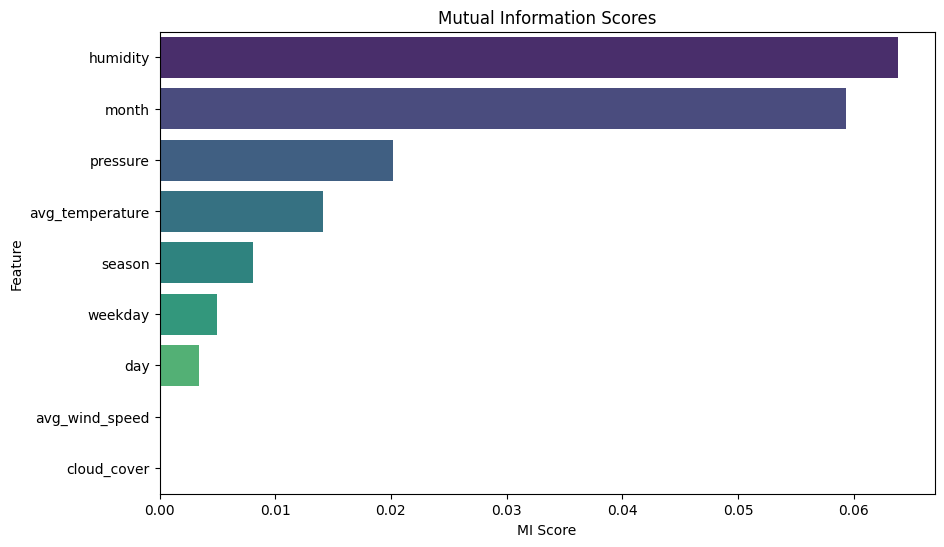

In [49]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns
import matplotlib.pyplot as plt


# Separate features and target
X = data.drop('rain_or_not', axis=1)  # Features
y = data['rain_or_not']  # Target

# Calculate MI scores
mi_scores = mutual_info_classif(X, y, random_state=42)

# Create a DataFrame to display MI scores
mi_df = pd.DataFrame({'Feature': X.columns, 'MI Score': mi_scores})
mi_df = mi_df.sort_values(by='MI Score', ascending=False)

print("Mutual Information Scores:")
print(mi_df)

# Plot MI scores
plt.figure(figsize=(10, 6))
sns.barplot(x='MI Score', y='Feature', data=mi_df, palette='viridis')
plt.title('Mutual Information Scores')
plt.xlabel('MI Score')
plt.ylabel('Feature')
plt.show()

# Model Comparison

Random Forest Accuracy: 0.68
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        22
           1       0.76      0.76      0.76        41

    accuracy                           0.68        63
   macro avg       0.65      0.65      0.65        63
weighted avg       0.68      0.68      0.68        63



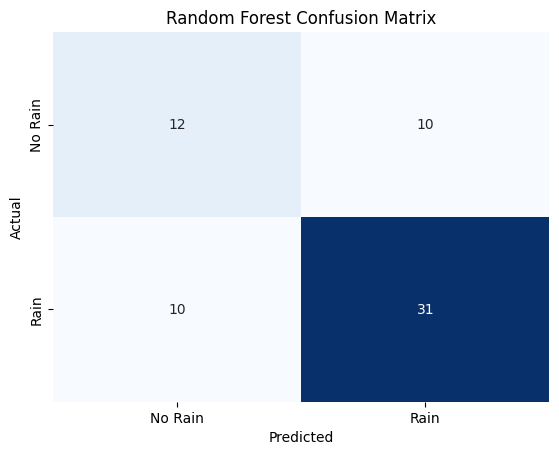

Gradient Boosting Accuracy: 0.56
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        22
           1       0.66      0.66      0.66        41

    accuracy                           0.56        63
   macro avg       0.51      0.51      0.51        63
weighted avg       0.56      0.56      0.56        63



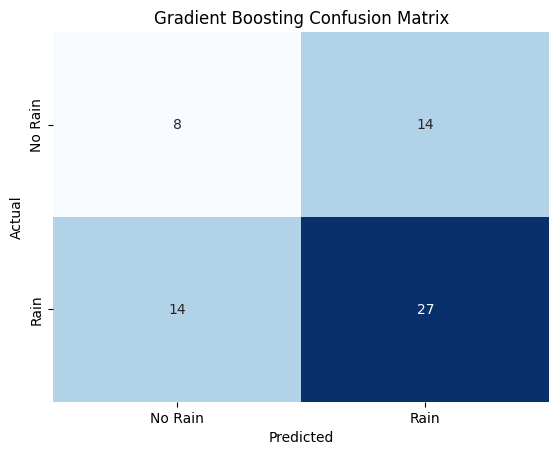

SVM Accuracy: 0.60
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.50      0.47        22
           1       0.71      0.66      0.68        41

    accuracy                           0.60        63
   macro avg       0.58      0.58      0.58        63
weighted avg       0.62      0.60      0.61        63



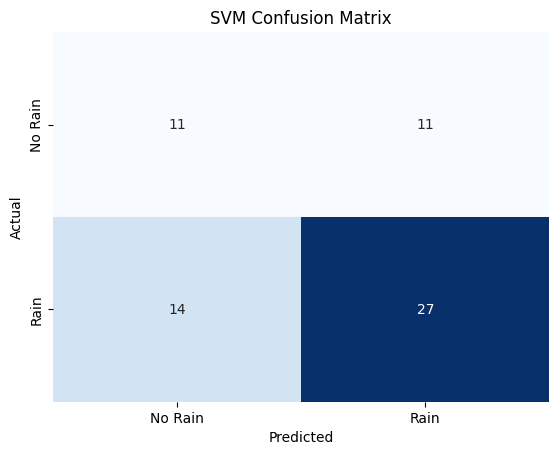

Logistic Regression Accuracy: 0.67
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        22
           1       0.73      0.78      0.75        41

    accuracy                           0.67        63
   macro avg       0.63      0.62      0.62        63
weighted avg       0.66      0.67      0.66        63



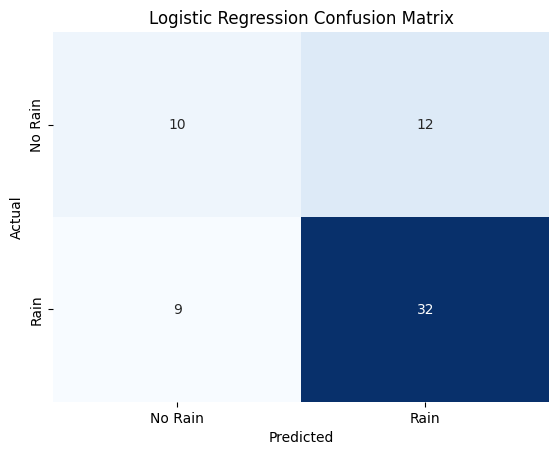

XGBoost Accuracy: 0.62
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        22
           1       0.73      0.66      0.69        41

    accuracy                           0.62        63
   macro avg       0.60      0.60      0.60        63
weighted avg       0.64      0.62      0.63        63



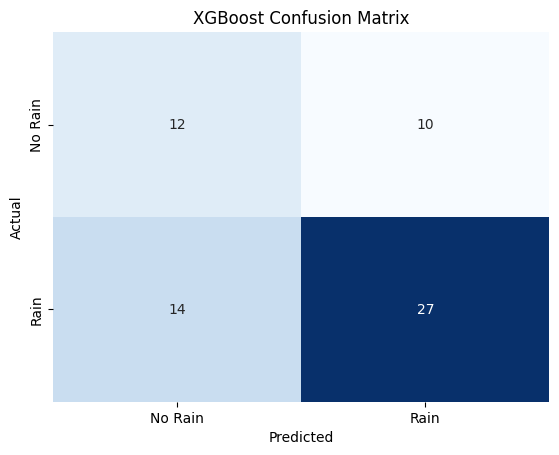

In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separate features and target
X = data.drop('rain_or_not', axis=1)  # Features
y = data['rain_or_not']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Function to plot confusion matrix using Seaborn
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Rain', 'Rain'],
                yticklabels=['No Rain', 'Rain'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=210, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix')

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
plot_confusion_matrix(y_test, y_pred_gb, 'Gradient Boosting Confusion Matrix')

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_scaled, y_train)
y_pred_svm = svm_model.predict(X_test_scaled)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.2f}')
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, 'SVM Confusion Matrix')

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression Confusion Matrix')

# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost Confusion Matrix')

# Feature Importance of RF Classifier

In [53]:
importances = rf_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df)

           Feature  Importance
1         humidity    0.168699
0  avg_temperature    0.146278
4         pressure    0.141687
2   avg_wind_speed    0.137787
3      cloud_cover    0.131219
8              day    0.104401
7            month    0.069535
6          weekday    0.066305
5           season    0.034089


# Model Comparison(With PCA)

Number of components after PCA: 7
Random Forest Accuracy: 0.65
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        22
           1       0.72      0.76      0.74        41

    accuracy                           0.65        63
   macro avg       0.61      0.61      0.61        63
weighted avg       0.64      0.65      0.65        63



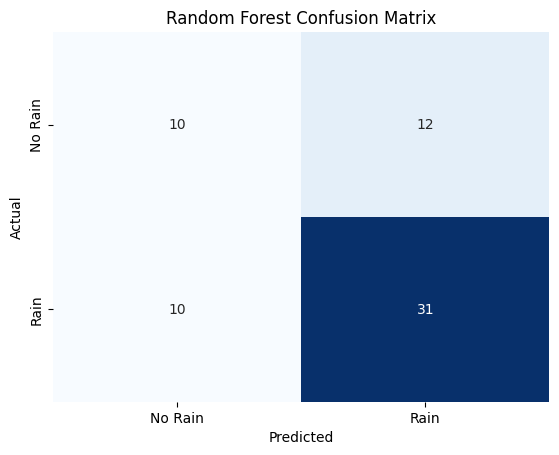

Gradient Boosting Accuracy: 0.65
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        22
           1       0.72      0.76      0.74        41

    accuracy                           0.65        63
   macro avg       0.61      0.61      0.61        63
weighted avg       0.64      0.65      0.65        63



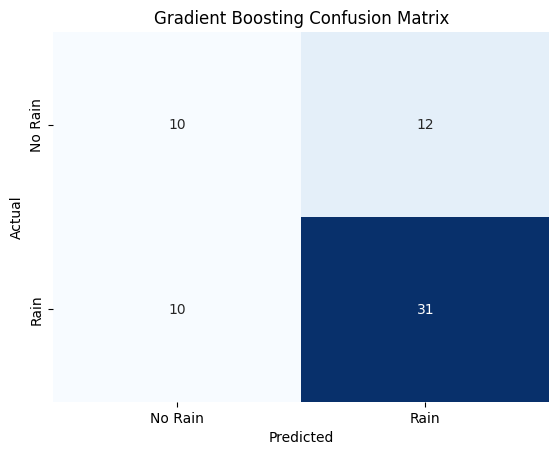

SVM Accuracy: 0.60
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.45      0.44        22
           1       0.70      0.68      0.69        41

    accuracy                           0.60        63
   macro avg       0.57      0.57      0.57        63
weighted avg       0.61      0.60      0.61        63



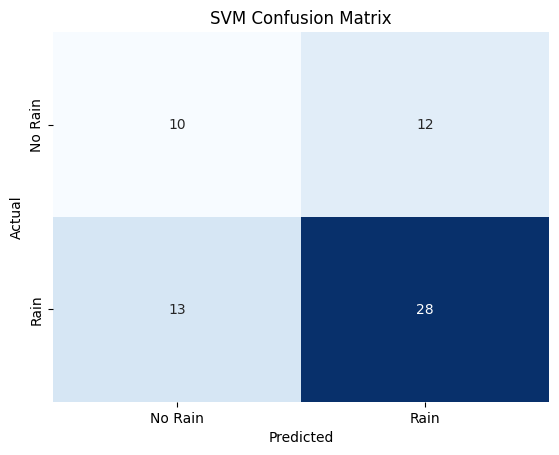

Logistic Regression Accuracy: 0.65
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.36      0.42        22
           1       0.70      0.80      0.75        41

    accuracy                           0.65        63
   macro avg       0.60      0.58      0.59        63
weighted avg       0.63      0.65      0.64        63



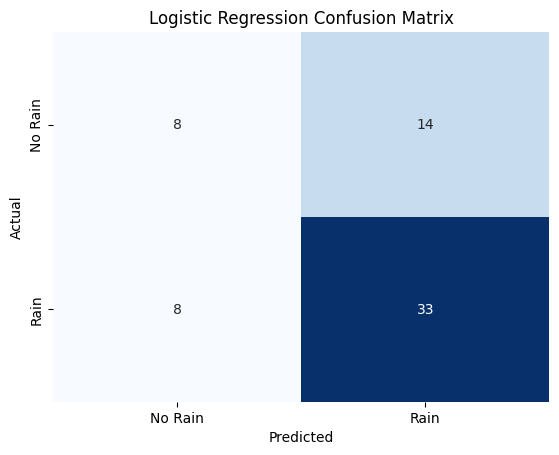

XGBoost Accuracy: 0.65
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50        22
           1       0.73      0.73      0.73        41

    accuracy                           0.65        63
   macro avg       0.62      0.62      0.62        63
weighted avg       0.65      0.65      0.65        63



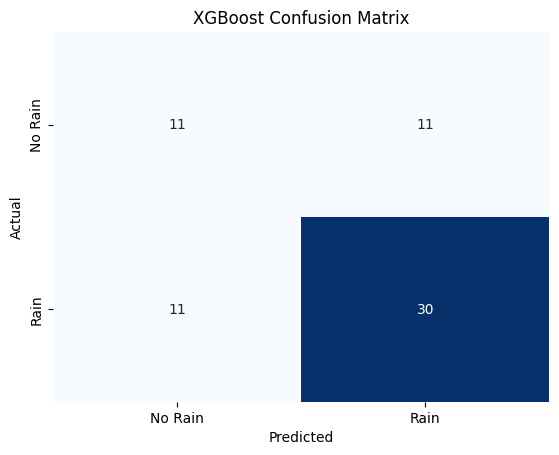

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separate features and target
X = data.drop('rain_or_not', axis=1)  # Features
y = data['rain_or_not']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Number of components after PCA: {pca.n_components_}")

# Function to plot confusion matrix using Seaborn
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Rain', 'Rain'],
                yticklabels=['No Rain', 'Rain'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=210, random_state=42)
rf_model.fit(X_train_pca, y_train)
y_pred_rf = rf_model.predict(X_test_pca)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix')

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_pca, y_train)
y_pred_gb = gb_model.predict(X_test_pca)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
plot_confusion_matrix(y_test, y_pred_gb, 'Gradient Boosting Confusion Matrix')

# Support Vector Machine (SVM)
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_pca, y_train)
y_pred_svm = svm_model.predict(X_test_pca)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.2f}')
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))
plot_confusion_matrix(y_test, y_pred_svm, 'SVM Confusion Matrix')

# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_pca, y_train)
y_pred_lr = lr_model.predict(X_test_pca)
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression Confusion Matrix')

# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_pca, y_train)
y_pred_xgb = xgb_model.predict(X_test_pca)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost Confusion Matrix')

With PCA, most of the models have achieved 0.65 accuracy but RF, Logistic Regression model accuracies have been reduced.

Random Forest Accuracy: 0.68
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.55      0.55        22
           1       0.76      0.76      0.76        41

    accuracy                           0.68        63
   macro avg       0.65      0.65      0.65        63
weighted avg       0.68      0.68      0.68        63



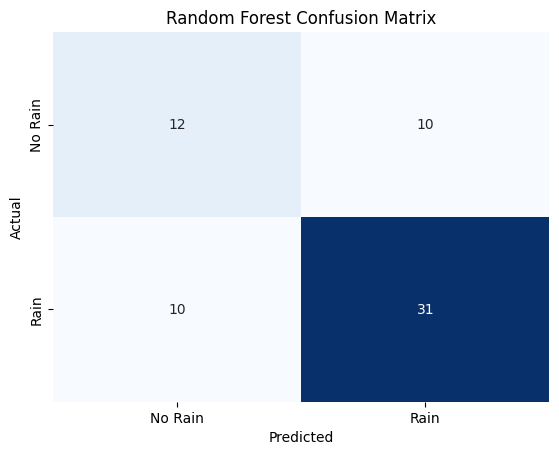

Random Forest Probability of Rain:
[63.33333333 91.42857143 52.85714286 61.9047619  77.61904762]

Gradient Boosting Accuracy: 0.56
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.36      0.36      0.36        22
           1       0.66      0.66      0.66        41

    accuracy                           0.56        63
   macro avg       0.51      0.51      0.51        63
weighted avg       0.56      0.56      0.56        63



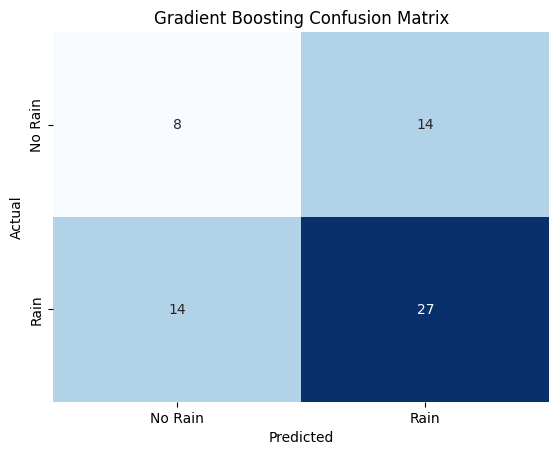

Gradient Boosting Probability of Rain:
[58.27149656 91.18877455 64.37763309 84.11551761 93.80785206]

Logistic Regression Accuracy: 0.67
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.45      0.49        22
           1       0.73      0.78      0.75        41

    accuracy                           0.67        63
   macro avg       0.63      0.62      0.62        63
weighted avg       0.66      0.67      0.66        63



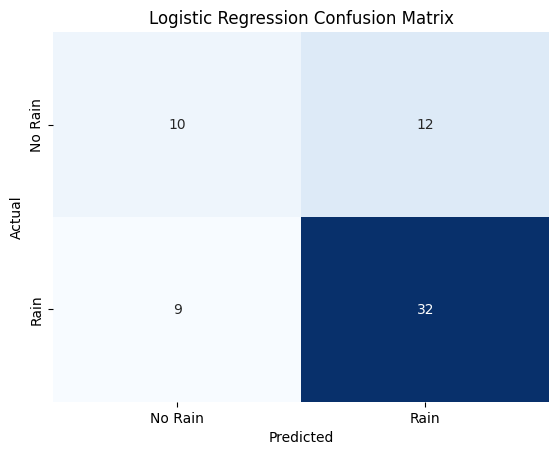

Logistic Regression Probability of Rain:
[80.17371382 88.95582044 73.63680966 80.05063564 92.88710725]

XGBoost Accuracy: 0.62
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.55      0.50        22
           1       0.73      0.66      0.69        41

    accuracy                           0.62        63
   macro avg       0.60      0.60      0.60        63
weighted avg       0.64      0.62      0.63        63



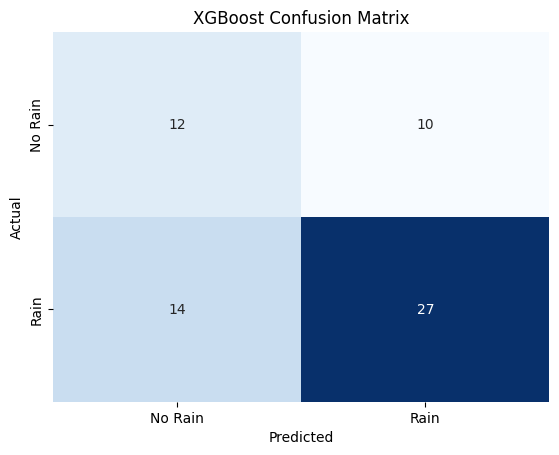

XGBoost Probability of Rain:
[96.70193  99.567345 67.662346 78.27364  93.72453 ]



In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Separate features and target
X = data.drop('rain_or_not', axis=1)  # Features
y = data['rain_or_not']  # Target

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Function to plot confusion matrix using Seaborn
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Rain', 'Rain'],
                yticklabels=['No Rain', 'Rain'])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Function to output probability of rain
def output_probability(y_pred_proba, model_name):
    # y_pred_proba is a 2D array: [probability of class 0, probability of class 1]
    # We are interested in the probability of class 1 (Rain)
    rain_probability = y_pred_proba[:, 1] * 100  # Convert to percentage
    print(f"{model_name} Probability of Rain:")
    print(rain_probability[:5])  # Print probabilities for the first 5 samples
    print()

# Random Forest
rf_model = RandomForestClassifier(n_estimators=210, random_state=42)
rf_model.fit(X_train_scaled, y_train)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)  # Get probabilities
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Random Forest Accuracy: {accuracy_rf:.2f}')
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest Confusion Matrix')
output_probability(y_pred_proba_rf, 'Random Forest')

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb_model.fit(X_train_scaled, y_train)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_proba_gb = gb_model.predict_proba(X_test_scaled)  # Get probabilities
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print(f'Gradient Boosting Accuracy: {accuracy_gb:.2f}')
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, y_pred_gb))
plot_confusion_matrix(y_test, y_pred_gb, 'Gradient Boosting Confusion Matrix')
output_probability(y_pred_proba_gb, 'Gradient Boosting')



# Logistic Regression
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)  # Get probabilities
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.2f}')
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))
plot_confusion_matrix(y_test, y_pred_lr, 'Logistic Regression Confusion Matrix')
output_probability(y_pred_proba_lr, 'Logistic Regression')

# XGBoost
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)  # Get probabilities
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print(f'XGBoost Accuracy: {accuracy_xgb:.2f}')
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost Confusion Matrix')
output_probability(y_pred_proba_xgb, 'XGBoost')